In [1]:
import azureml.core
from azureml.core import Workspace

#check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.0.17


In [17]:
#load workspace configuration from the config.json file in the current folder
ws = Workspace.from_config()
print(ws.name, ws.location, ws.resource_group, ws.location, sep = '\t')

Found the config file in: C:\Users\dt\notebooks\MachineLearningNotebooks\aml_config\config.json
workspace	eastus2	exmachina	eastus2


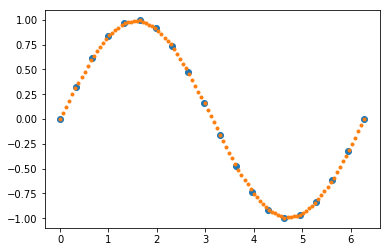

In [26]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from azureml.core import Experiment
exp = Experiment(workspace=ws, name='minimal')

#start a run and start the logging service
run = exp.start_logging()

#log a single  number
run.log('the answer', 42)

#log a list (Fibonacci numbers)
run.log_list('Fibonacci', [1, 1, 2, 3, 5, 8, 13, 21, 34, 55])

#graph
x = np.linspace(0, 2 * np.pi, 20)
y = np.sin(x)
yp = None
xi = np.linspace(x[0], x[-1], 100)
yi = np.interp(xi, x, y, yp)

fig, ax = plt.subplots()
ax.plot(x, y, 'o', xi, yi, '.')
plt.show()

#log graph
run.log_image('plot', path=None, plot=fig)

#finish the run
run.complete()

In [46]:
import os
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.externals import joblib
from azureml.core.model import Model
from azureml.core import Experiment
exp = Experiment(workspace=ws, name='mini')

run = exp.start_logging()

f = lambda x: x+13

X_train = np.arange( 1.0, 1000.0, 2.0 )
y_train = f( X_train )
X_test = np.array ( [ 2.0, 4.0, 6.0 ] )
y_test = f( X_test )

clf = LinearRegression()
clf.fit( X_train.reshape( -1, 1 ), y_train )

y_hat = clf.predict( X_test.reshape( -1, 1 ) )

#print(X_train)
#print(y_train)
print(y_test)
print(y_hat)

acc = np.average( ( y_hat - y_test ) < .00000001 ) 
print( 'Accuracy', acc )
run.log( 'Accuracy', acc )

os.makedirs( 'outputs', exist_ok=True )
# note file saved in the outputs folder is automatically uploaded into experiment record
joblib.dump( value=clf, filename='outputs/mini.pkl' )

model = Model.register( model_path='outputs/mini.pkl',
                        model_name='mini',
                        tags={ "data": 'fabricated', 'model': 'regression' },
                        description='basic regression',
                        workspace=ws )

run.complete()

[15. 17. 19.]
[15. 17. 19.]
Accuracy 1.0
Registering model mini


In [48]:
%%writefile score.py

#run in a separate folder -- so no name collisions

import json
import numpy as np
import os
import pickle
from sklearn.externals import joblib
from sklearn.linear_model import LinearRegression

from azureml.core.model import Model

def init():
    global model
    # retrieve the path to the model file using the model name
    model_path = Model.get_model_path('mini')
    model = joblib.load(model_path)

def run(raw_data):
    data = np.array(json.loads(raw_data)['data'])
    # make prediction
    y_hat = model.predict(data)
    # you can return any data type as long as it is JSON-serializable
    return y_hat.tolist()

Writing score.py


In [49]:
from azureml.core.conda_dependencies import CondaDependencies 

myenv = CondaDependencies()
myenv.add_conda_package("scikit-learn")

with open("myenv.yml","w") as f:
    f.write(myenv.serialize_to_string())

In [50]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                               memory_gb=1, 
                                               tags={"data": "fabricated",  "method" : "sklearn"}, 
                                               description='Predict linear regression with sklearn')

In [51]:
%%time
from azureml.core.webservice import Webservice
from azureml.core.image import ContainerImage

# configure the image
image_config = ContainerImage.image_configuration(execution_script="score.py", 
                                                  runtime="python", 
                                                  conda_file="myenv.yml")

#model needs to be the registered model, from above, i believe

service = Webservice.deploy_from_model(workspace=ws,
                                       name='mini-svc',
                                       deployment_config=aciconfig,
                                       models=[model],
                                       image_config=image_config)

service.wait_for_deployment(show_output=True)

Creating image
Image creation operation finished for image mini-svc:1, operation "Succeeded"
Creating service
Running..................
SucceededACI service creation operation finished, operation "Succeeded"
Wall time: 7min 18s


In [55]:
import requests

input_data = "{\"data\": [ [ " + str( 2.0 ) + "] ] }"

headers = {'Content-Type':'application/json'}

# for AKS deployment you'd need to the service key in the header as well
# api_key = service.get_key()
# headers = {'Content-Type':'application/json',  'Authorization':('Bearer '+ api_key)} 

resp = requests.post( service.scoring_uri, input_data, headers=headers )

print( "POST to url", service.scoring_uri )
#print( "input data:", input_data )
print("truth: ", 15.0 )
print("prediction:", resp.text)

POST to url http://20.185.99.15:80/score
truth:  15.0
prediction: [14.999999999999773]


In [56]:
service.delete()